$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Big Data Research

*Jason Stock*

In [41]:
import pandas as pd
import numpy as np 
import random
import time
from pprint import pprint
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib as mpl
import neuralnetworks as nn
import mlutils as ml
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
mpl.style.use('default')

### Functions
Same `trainNNs, summarize, bestNetwork, printBest` from PA5.

In [2]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures,
             numberRepetitions, numberIterations, classify = False):
    train_p, test_p, timing = [], [], []
    for network in hiddenLayerStructures:
        l_train_p, l_test_p = [], []
        sT = time.time()
        for rep in range(0, numberRepetitions):
            Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T,
                                                        (trainFraction, 1 - trainFraction),
                                                        classification = classify)
            if classify:
                nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1],
                                                  network,
                                                  np.unique(T).shape[0])
                nnet.train(Xtrain, Ttrain, numberIterations)
                
                Ytrain = nnet.use(Xtrain)
                Ytest  = nnet.use(Xtest)
                
                l_train_p.append( np.sum(Ytrain!=Ttrain)/len(Ttrain) )
                l_test_p.append( np.sum(Ytest!=Ttest)/len(Ttest) )
            else:
                nnet = nn.NeuralNetwork(Xtrain.shape[1],
                                        network,
                                        Ttrain.shape[1])
                nnet.train(Xtrain, Ttrain, numberIterations)
    
                Ytrain = nnet.use(Xtrain)
                Ytest  = nnet.use(Xtest)
            
                l_train_p.append( np.mean( (Ytrain - Ttrain)**2) )
                l_test_p.append( np.mean( (Ytest  - Ttest )**2) )

        timing.append((time.time() - sT))
        
        train_p.append(l_train_p)
        
        test_p.append(l_test_p)
        
    return [ [hiddenLayerStructures[i], train_p[i], test_p[i], timing[i]]
                for i in range(0, len(hiddenLayerStructures)) ]

def summarize(results):
    for i in range(0, len(results)):
        results[i][1] = np.mean(results[i][1])
        results[i][2] = np.mean(results[i][2])
    
    return results

def bestNetwork(summary):
    min_index = np.argmin( [ [x[2]] for x in summary ] )
    return summary[min_index]

def printBest(best):
    print('\nBest:', best)
    print('\nHidden Layers {} Average Training {:.2f} Testing {:.2f} ' \
          'Took {:.4f} seconds'.format(*best))

### Data Analysis

I begin by looking at the input features to see how they are distributed and correlate to eachother.

Since the weather is consistent across all files (wc1.csv, wc2.csv, ..., wc3.csv) we can just look at one for correlations.

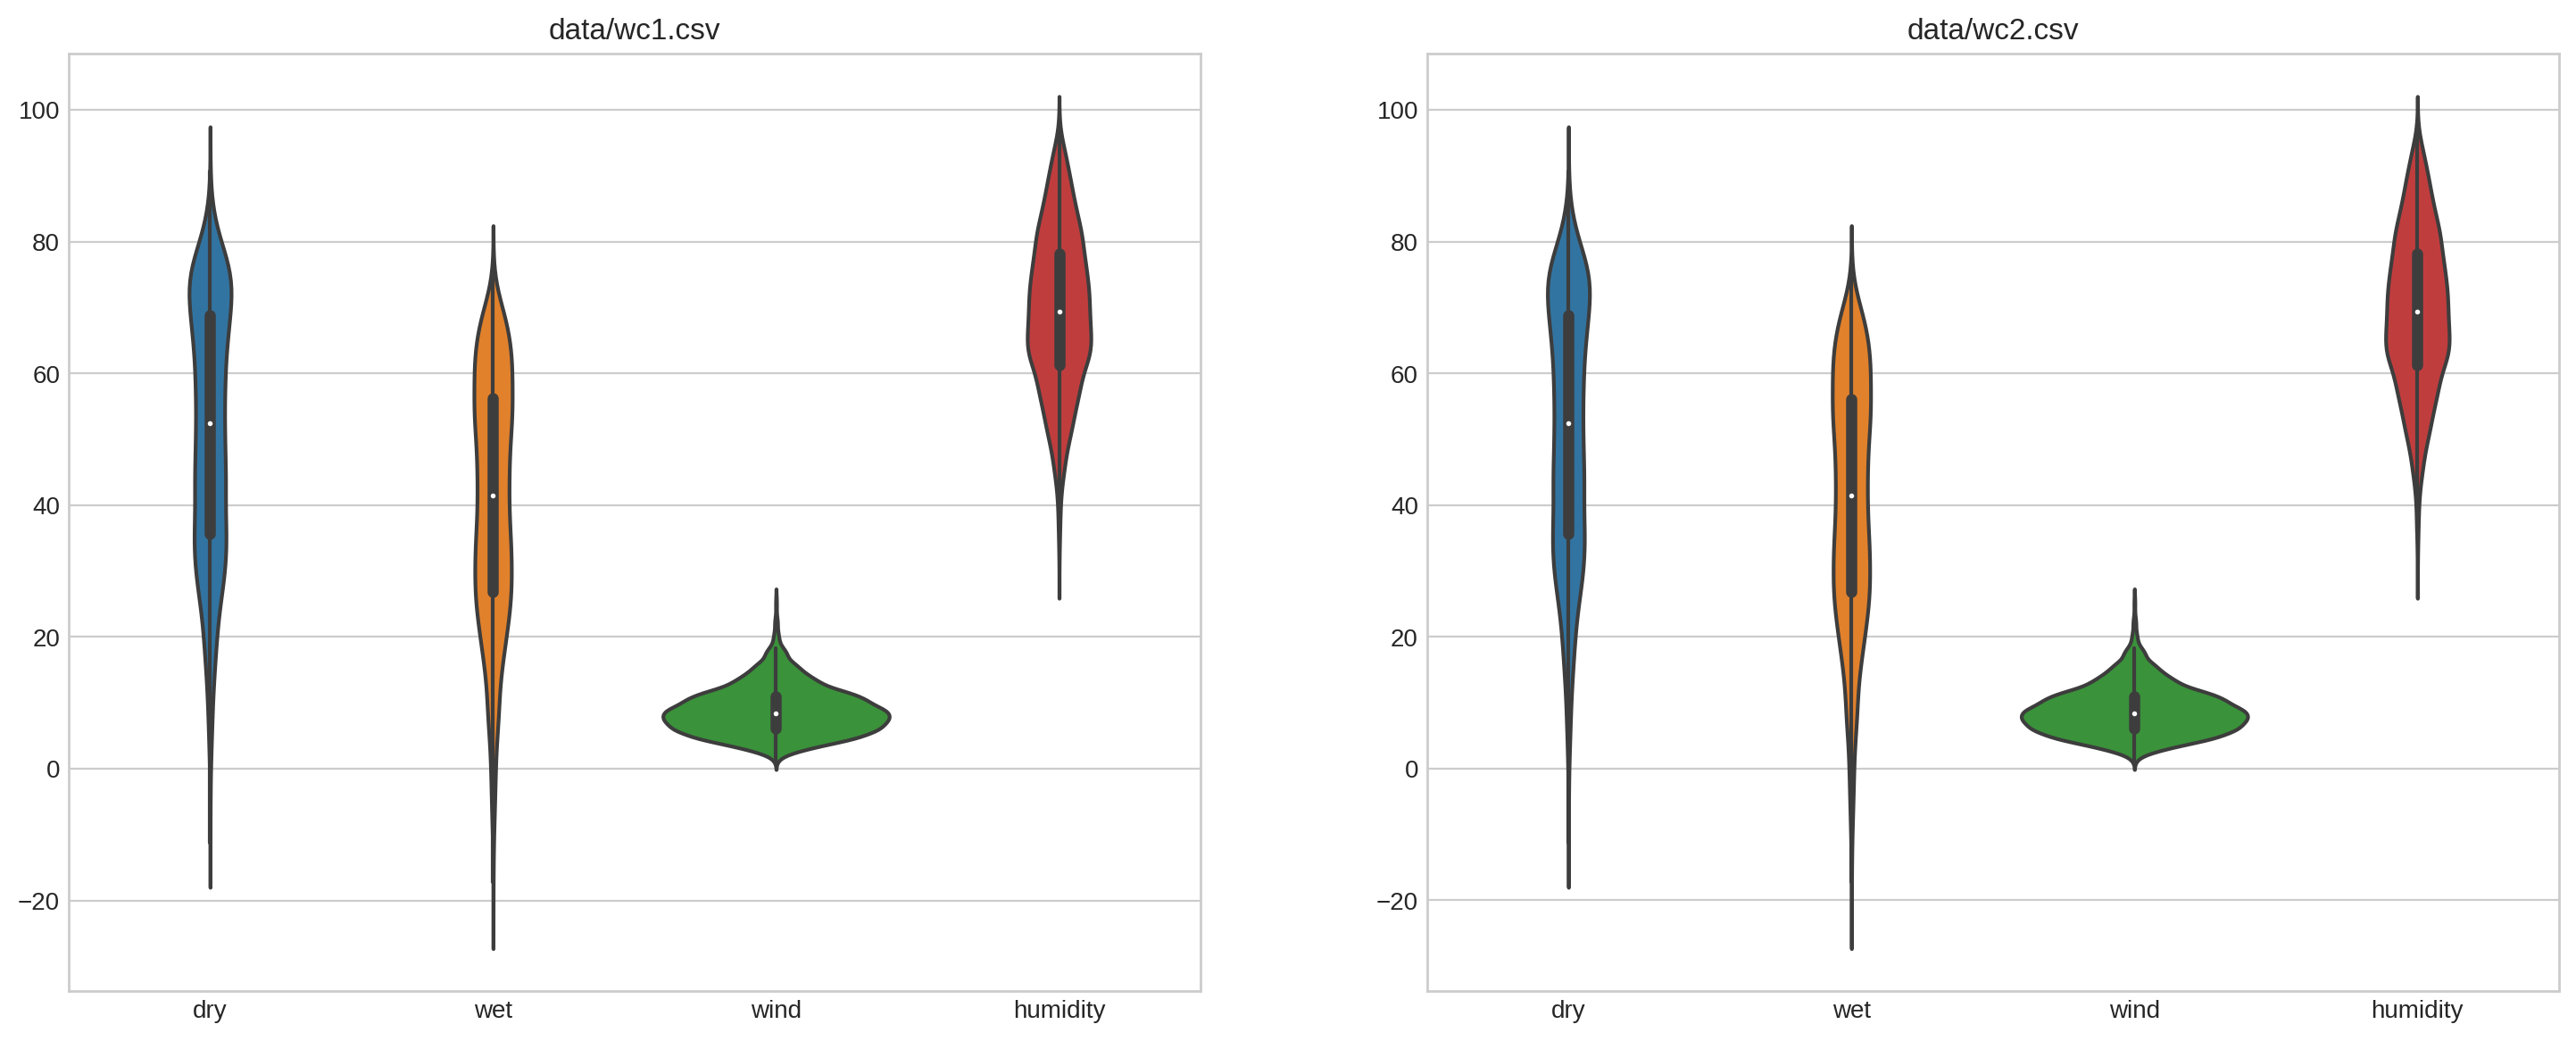

In [37]:
# #############################################################################
# Combination of boxplot and kernel density estimate for Wx data.

sns.set_style('whitegrid')

plt.figure(figsize=(18,15))

NUM_PLOTS = 2

for i in range(NUM_PLOTS):
    plt.subplot((NUM_PLOTS + 2)/2,2,i+1)
    file = 'data/wc'+str(i+1)+'.csv'
    weather = pd.read_csv(file, sep=',', low_memory=False, 
                           names = ['date', 'dry', 'wet', 'wind',
                                    'humidity', 'district', 'homicide', 'robbery',
                                    'battery', 'assault', 'burglary', 'theft',
                                    'motor', 'weapons'], usecols = range(5))
    plt.title(file)
    sns.violinplot(data=weather)

plt.show()

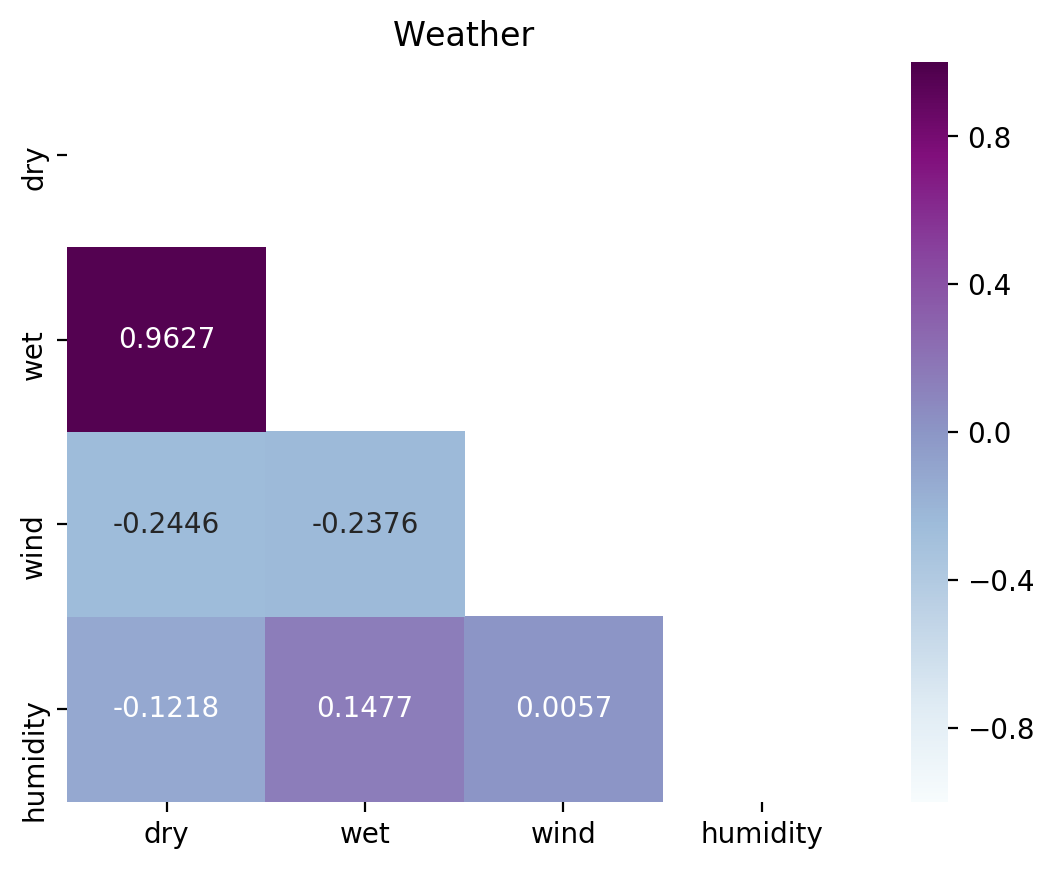

In [47]:
# #############################################################################
# Heatmap from the laster weather set of weather data read

corr = weather.corr()
mask = np.zeros_like(corr,dtype=np.bool)

# set to False to view full matrix
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, fmt='.4f', mask=mask, cmap='BuPu', robust=True)
plt.title('Weather')

plt.show()

In [48]:
# #############################################################################
# Read in data for rest of experiments

data = pd.read_csv('data/wc4.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [49]:
# #############################################################################
# Sample the data

data.head()

,date,dry,wet,wind,humidity,district,homicide,robbery,battery,assault,burglary,theft,motor,weapons
0,01/01/2002,0.292653,0.278099,0.168791,0.424481,4,0,0,0,0,0,10,0,0
1,01/01/2003,0.411195,0.444405,0.654298,0.598966,4,0,2,31,6,1,29,3,1
2,01/01/2004,0.484048,0.526894,0.295902,0.637780,4,0,1,30,5,1,51,2,0
3,01/01/2005,0.442947,0.498878,0.431738,0.710753,4,0,3,33,3,2,35,0,0
4,01/01/2006,0.486295,0.555700,0.294203,0.766484,4,0,1,32,2,1,43,3,0


In [50]:
# #############################################################################
# Check for NaN / Missing values and dtype

data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6418 entries, 0 to 6417
Data columns (total 14 columns):
date        6418 non-null object
dry         6418 non-null float64
wet         6418 non-null float64
wind        6418 non-null float64
humidity    6418 non-null float64
district    6418 non-null int64
homicide    6418 non-null int64
robbery     6418 non-null int64
battery     6418 non-null int64
assault     6418 non-null int64
burglary    6418 non-null int64
theft       6418 non-null int64
motor       6418 non-null int64
weapons     6418 non-null int64
dtypes: float64(4), int64(9), object(1)
memory usage: 702.0+ KB


In [51]:
# #############################################################################
# Descriptive statistics that summarize the central tendency, 
# dispersion and shape of the entire data distribution

data.describe()

,dry,wet,wind,humidity,district,homicide,robbery,battery,assault,burglary,theft,motor,weapons
count,6418.000000,6418.000000,6418.000000,6418.000000,6418.0,6418.000000,6418.000000,6418.000000,6418.000000,6418.000000,6418.000000,6418.000000,6418.000000
mean,0.613621,0.633865,0.309116,0.580863,4.0,0.022437,1.598006,7.563571,2.676067,1.266438,27.279371,1.441415,0.231225
std,0.191140,0.191428,0.146122,0.176257,0.0,0.156302,1.453387,4.196115,1.942349,1.351696,10.807769,1.373772,0.513320
min,0.000000,0.000000,0.000000,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.459073,0.492179,0.200892,0.459322,4.0,0.000000,0.000000,5.000000,1.000000,0.000000,22.000000,0.000000,0.000000
50%,0.624999,0.643002,0.293109,0.579845,4.0,0.000000,1.000000,7.000000,2.000000,1.000000,28.000000,1.000000,0.000000
75%,0.784852,0.794861,0.396454,0.710703,4.0,0.000000,2.000000,10.000000,4.000000,2.000000,34.000000,2.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,4.0,3.000000,10.000000,38.000000,13.000000,9.000000,142.000000,10.000000,4.000000


### Neural Network

Using SGD from Dr. Anderson by use of the NN package.

In [52]:
# #############################################################################
# Read in X and T by items in a list, e.g., [2, 3, 5], range(5), etc.

def sampler(data, a, b):
    
    X = data.iloc[:, np.r_[a]]
    T = data.iloc[:, np.r_[b]]
        
    return np.array(X), np.array(T)

X, T = sampler(data, range(1,5), range(6,14)) # 6,14

In [53]:
X[:5], T[:5]

(array([[0.29265347, 0.27809924, 0.16879074, 0.42448062],
        [0.41119535, 0.44440535, 0.65429849, 0.59896641],
        [0.4840483 , 0.52689439, 0.29590154, 0.63777973],
        [0.44294716, 0.49887847, 0.43173778, 0.71075333],
        [0.48629542, 0.5557001 , 0.29420259, 0.76648401]]),
 array([[ 0,  0,  0,  0,  0, 10,  0,  0],
        [ 0,  2, 31,  6,  1, 29,  3,  1],
        [ 0,  1, 30,  5,  1, 51,  2,  0],
        [ 0,  3, 33,  3,  2, 35,  0,  0],
        [ 0,  1, 32,  2,  1, 43,  3,  0]]))

In [19]:
# #############################################################################
# Return predicted values from training and running

def get_values(X, T, network, train_f, itr, partition = False):
    if partition: 
        Xtrain, Ttrain, Xtest, T = ml.partition(X, T, (train_f, 1 - train_f))
        
        nnet = nn.NeuralNetwork(Xtrain.shape[1], network, Ttrain.shape[1])
        nnet.train(Xtrain, Ttrain, itr)
        Y = nnet.use(Xtest)
        
    else:  
        nnet = nn.NeuralNetwork(X.shape[1], network, T.shape[1]) 
        nnet.train(X, T, itr)
        Y = nnet.use(X)
        
    return Y, T, nnet.getErrorTrace()

Network 1: [42, 42, 42] with 1200 iterations.
Network 2: [74, 74, 74] with 1260 iterations.
Network 3: [58, 58, 58, 58] with 1323 iterations.
Network 4: [65, 65, 65, 65, 65] with 1389 iterations.
Network 5: [54, 54, 54, 54, 54] with 1458 iterations.
Network 6: [55, 55, 55, 55] with 1530 iterations.
Network 7: [71, 71, 71] with 1606 iterations.
Network 8: [44, 44, 44] with 1686 iterations.
Network 9: [71, 71, 71, 71, 71] with 1770 iterations.
Network 10: [72, 72, 72, 72] with 1858 iterations.
Network 11: [48, 48, 48] with 1950 iterations.
Network 12: [65, 65, 65, 65] with 2047 iterations.
Network 13: [70, 70, 70, 70, 70] with 2149 iterations.
Network 14: [39, 39, 39, 39] with 2256 iterations.
Network 15: [43, 43, 43] with 2368 iterations.
Network 16: [45, 45, 45] with 2486 iterations.
Network 17: [39, 39, 39, 39, 39] with 2610 iterations.
Network 18: [73, 73, 73] with 2740 iterations.
Network 19: [67, 67, 67, 67, 67] with 2877 iterations.
Network 20: [73, 73, 73, 73, 73] with 3020 itera

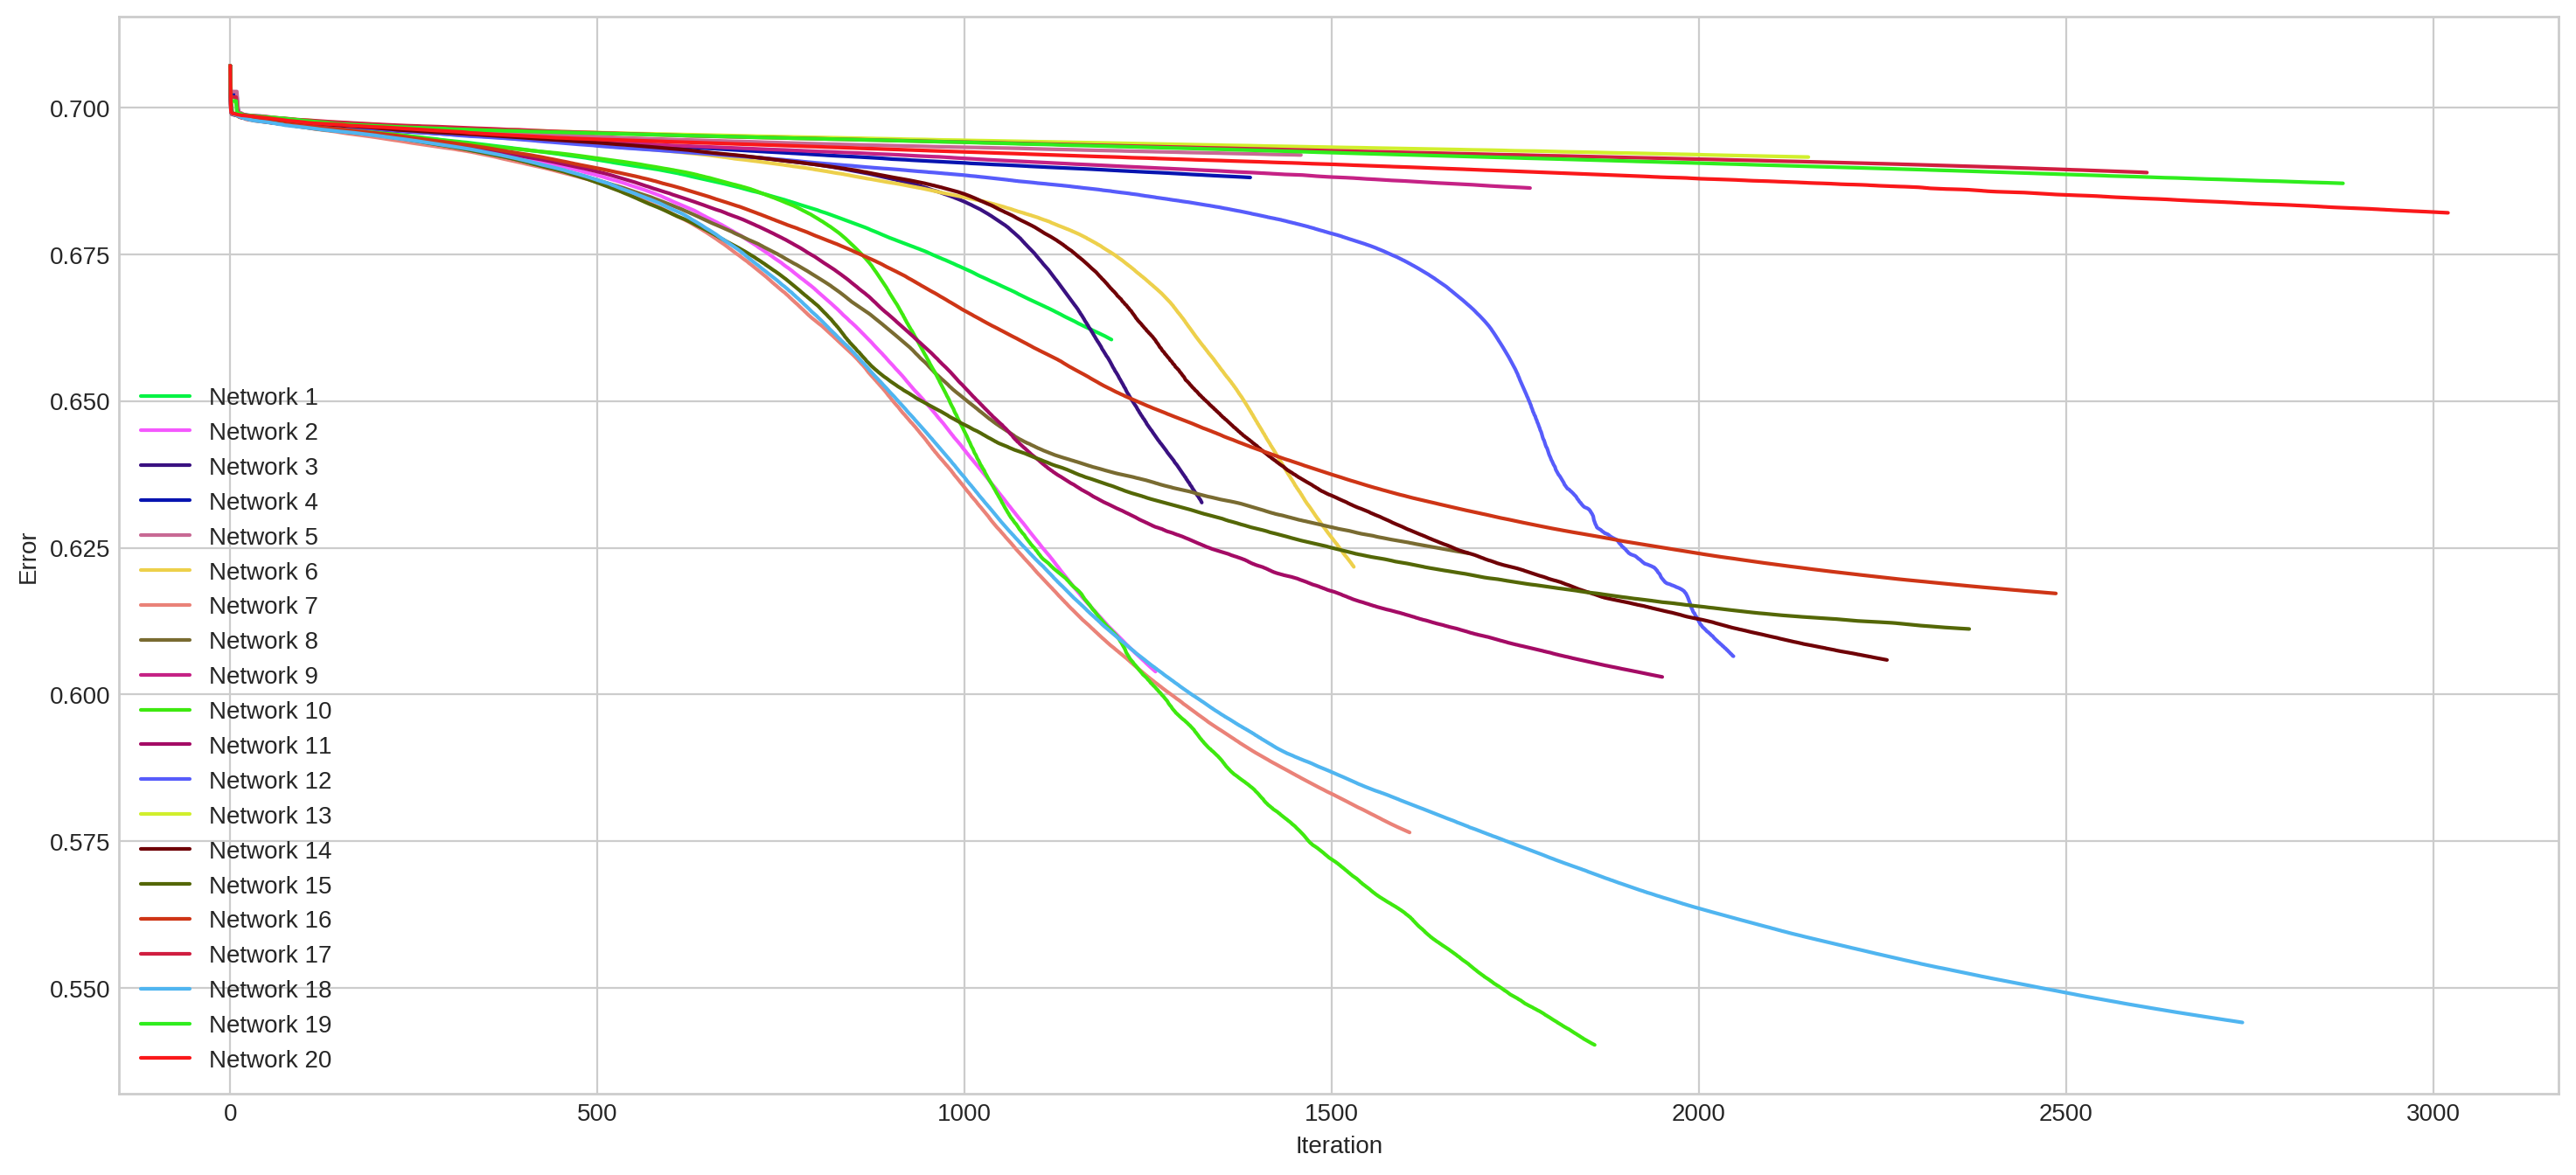

In [67]:
# #############################################################################
# Look at Error / Network / Iterations

sns.set_style("whitegrid")

numberItr = 1200
train_f = 0.8
er = []

for i in range(20):
    a = np.random.randint(35, 75)
    b = np.random.randint(3, 6)
    print('Network', str(i+1) + ':', [a]*b,
          'with', numberItr, 'iterations.')

    Y, _T, error = get_values(X, T, [a]*b, train_f, numberItr)
    er.append(error)
    numberItr = int(1.05 * numberItr)

plt.figure(figsize=(18,8))
for i, pl in enumerate(er):
    plt.plot(pl, c=np.random.rand(3,), label = 'Network '+str(i+1))

plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

In [21]:
# #############################################################################
# Deeper network.  Found no difference when running.

'''
numberItr = 500
er = []

for i in range(14):
    a = np.random.randint(1, 50)
    b = np.random.randint(5, 20)
    print('Network', str(i+1) + ':', [a]*b,
          'with', numberItr, 'iterations.')

    Y, _T, error = get_values(X, T, [a]*b, train_f, numberItr)
    er.append(error)
    numberItr = int(1.15 * numberItr)

plt.figure(figsize=(18,6))
for i, pl in enumerate(er):
    plt.plot(pl, label = 'Network '+str(i+1))

plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()
'''
print('check')

check


In [68]:
# #############################################################################
# Retrieve the best NN structure.  
# Best seen [67, 67, 67, 67] 2000 80/20 District 4
# MIN ERROR 0.49223388006888474, RMSE: 33.93454955140849
# [72, 72, 72, 72]
# ERROR MIN: 0.46960927770591065, RMSE: 35.984220552712344

itr = 2000
hidden = []
trainFraction = 0.20
numberRepetitions = 2

for i in range(8):
    a = np.random.randint(35, 75)
    b = np.random.randint(3, 6)
    hidden.append([a]*b)

results = trainNNs(X, T, trainFraction, hidden,
                   numberRepetitions, itr)
summary = summarize(results)
best    = bestNetwork(summary)

pprint(summary)
printBest(best)

[[[72, 72, 72, 72, 72],
  11.155112275572623,
  26.600154668968393,
  55.575669050216675],
 [[58, 58, 58], 4.56988340760799, 73.14912385947133, 27.813891172409058],
 [[60, 60, 60, 60, 60],
  7.078096402416055,
  38.078745551328595,
  45.92835354804993],
 [[54, 54, 54], 4.982061177956664, 60.46499851859251, 26.4754855632782],
 [[67, 67, 67], 3.240618296605536, 61.6224376385341, 32.13322854042053],
 [[62, 62, 62, 62], 1.8883475713652258, 57.218408786905826, 38.817649602890015],
 [[53, 53, 53, 53], 2.5782093722304076, 59.573280119705956, 33.34746837615967],
 [[73, 73, 73, 73], 0.8832781245219379, 60.18247669603547, 46.86253643035889]]

Best: [[72, 72, 72, 72, 72], 11.155112275572623, 26.600154668968393, 55.575669050216675]

Hidden Layers [72, 72, 72, 72, 72] Average Training 11.16 Testing 26.60 Took 55.5757 seconds


Network: [72, 72, 72, 72, 72]
ERROR MIN: 0.6748069437340833 for 2000 iterations
RMSE: 18.20180185948297


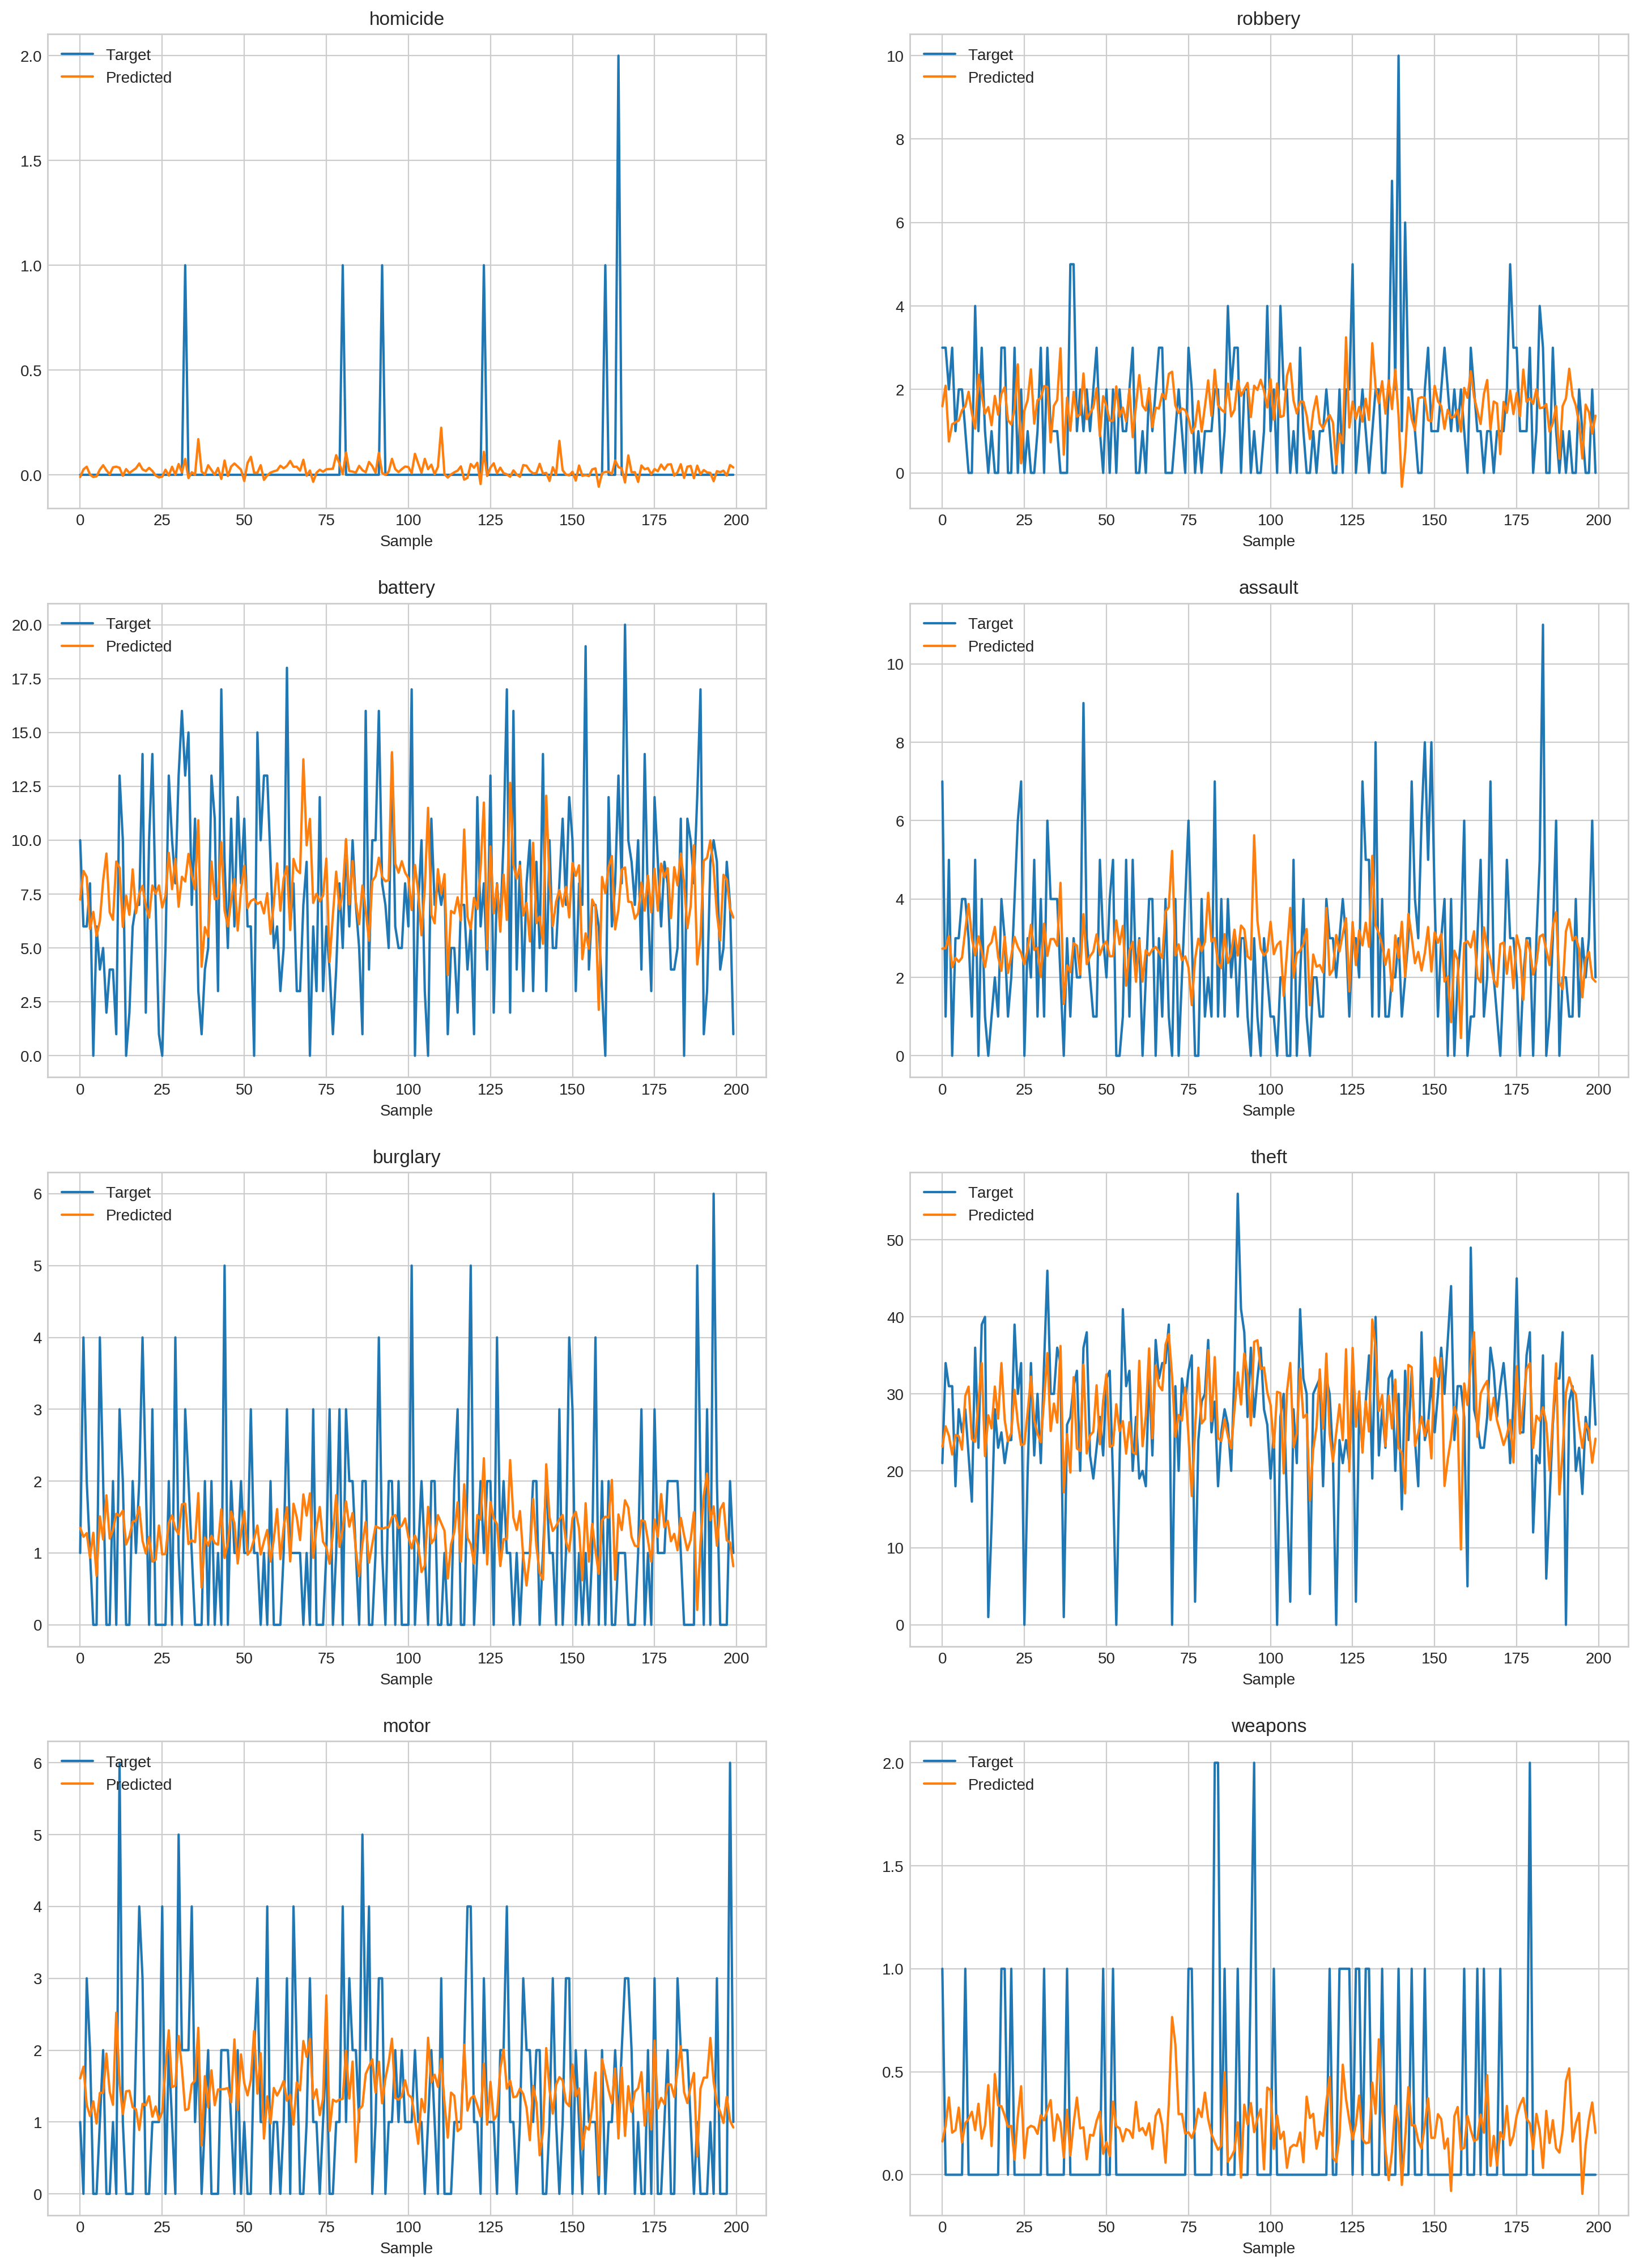

In [73]:
# #############################################################################
# Use the best network
    
itr = 2000
train_f = 0.8

network = best[0]
print('Network:', network)
Y, _T, error = get_values(X, T, network, train_f, itr, partition = True)

# #############################################################################
# Results V1.  Showing first 200 samples 

def data_plot(Y, T, error, itr, bound):
    print('ERROR MIN:', np.min(error), 'for', itr, 'iterations')
    print('RMSE:', np.mean((Y - T)**2))
    col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']
    
    plt.figure(figsize=(18,25))
    for i in range(T.shape[1]):
        plt.subplot(4,2,i+1)  
        plt.plot(T[:bound,i]), plt.plot(Y[:bound,i])
        plt.title(col[i])
        plt.xlabel('Sample'), plt.ylabel('')
        plt.legend(['Target', 'Predicted'], loc='upper left')
    
    plt.show() 
    
bound = 200
data_plot(Y, _T, error, itr, bound)

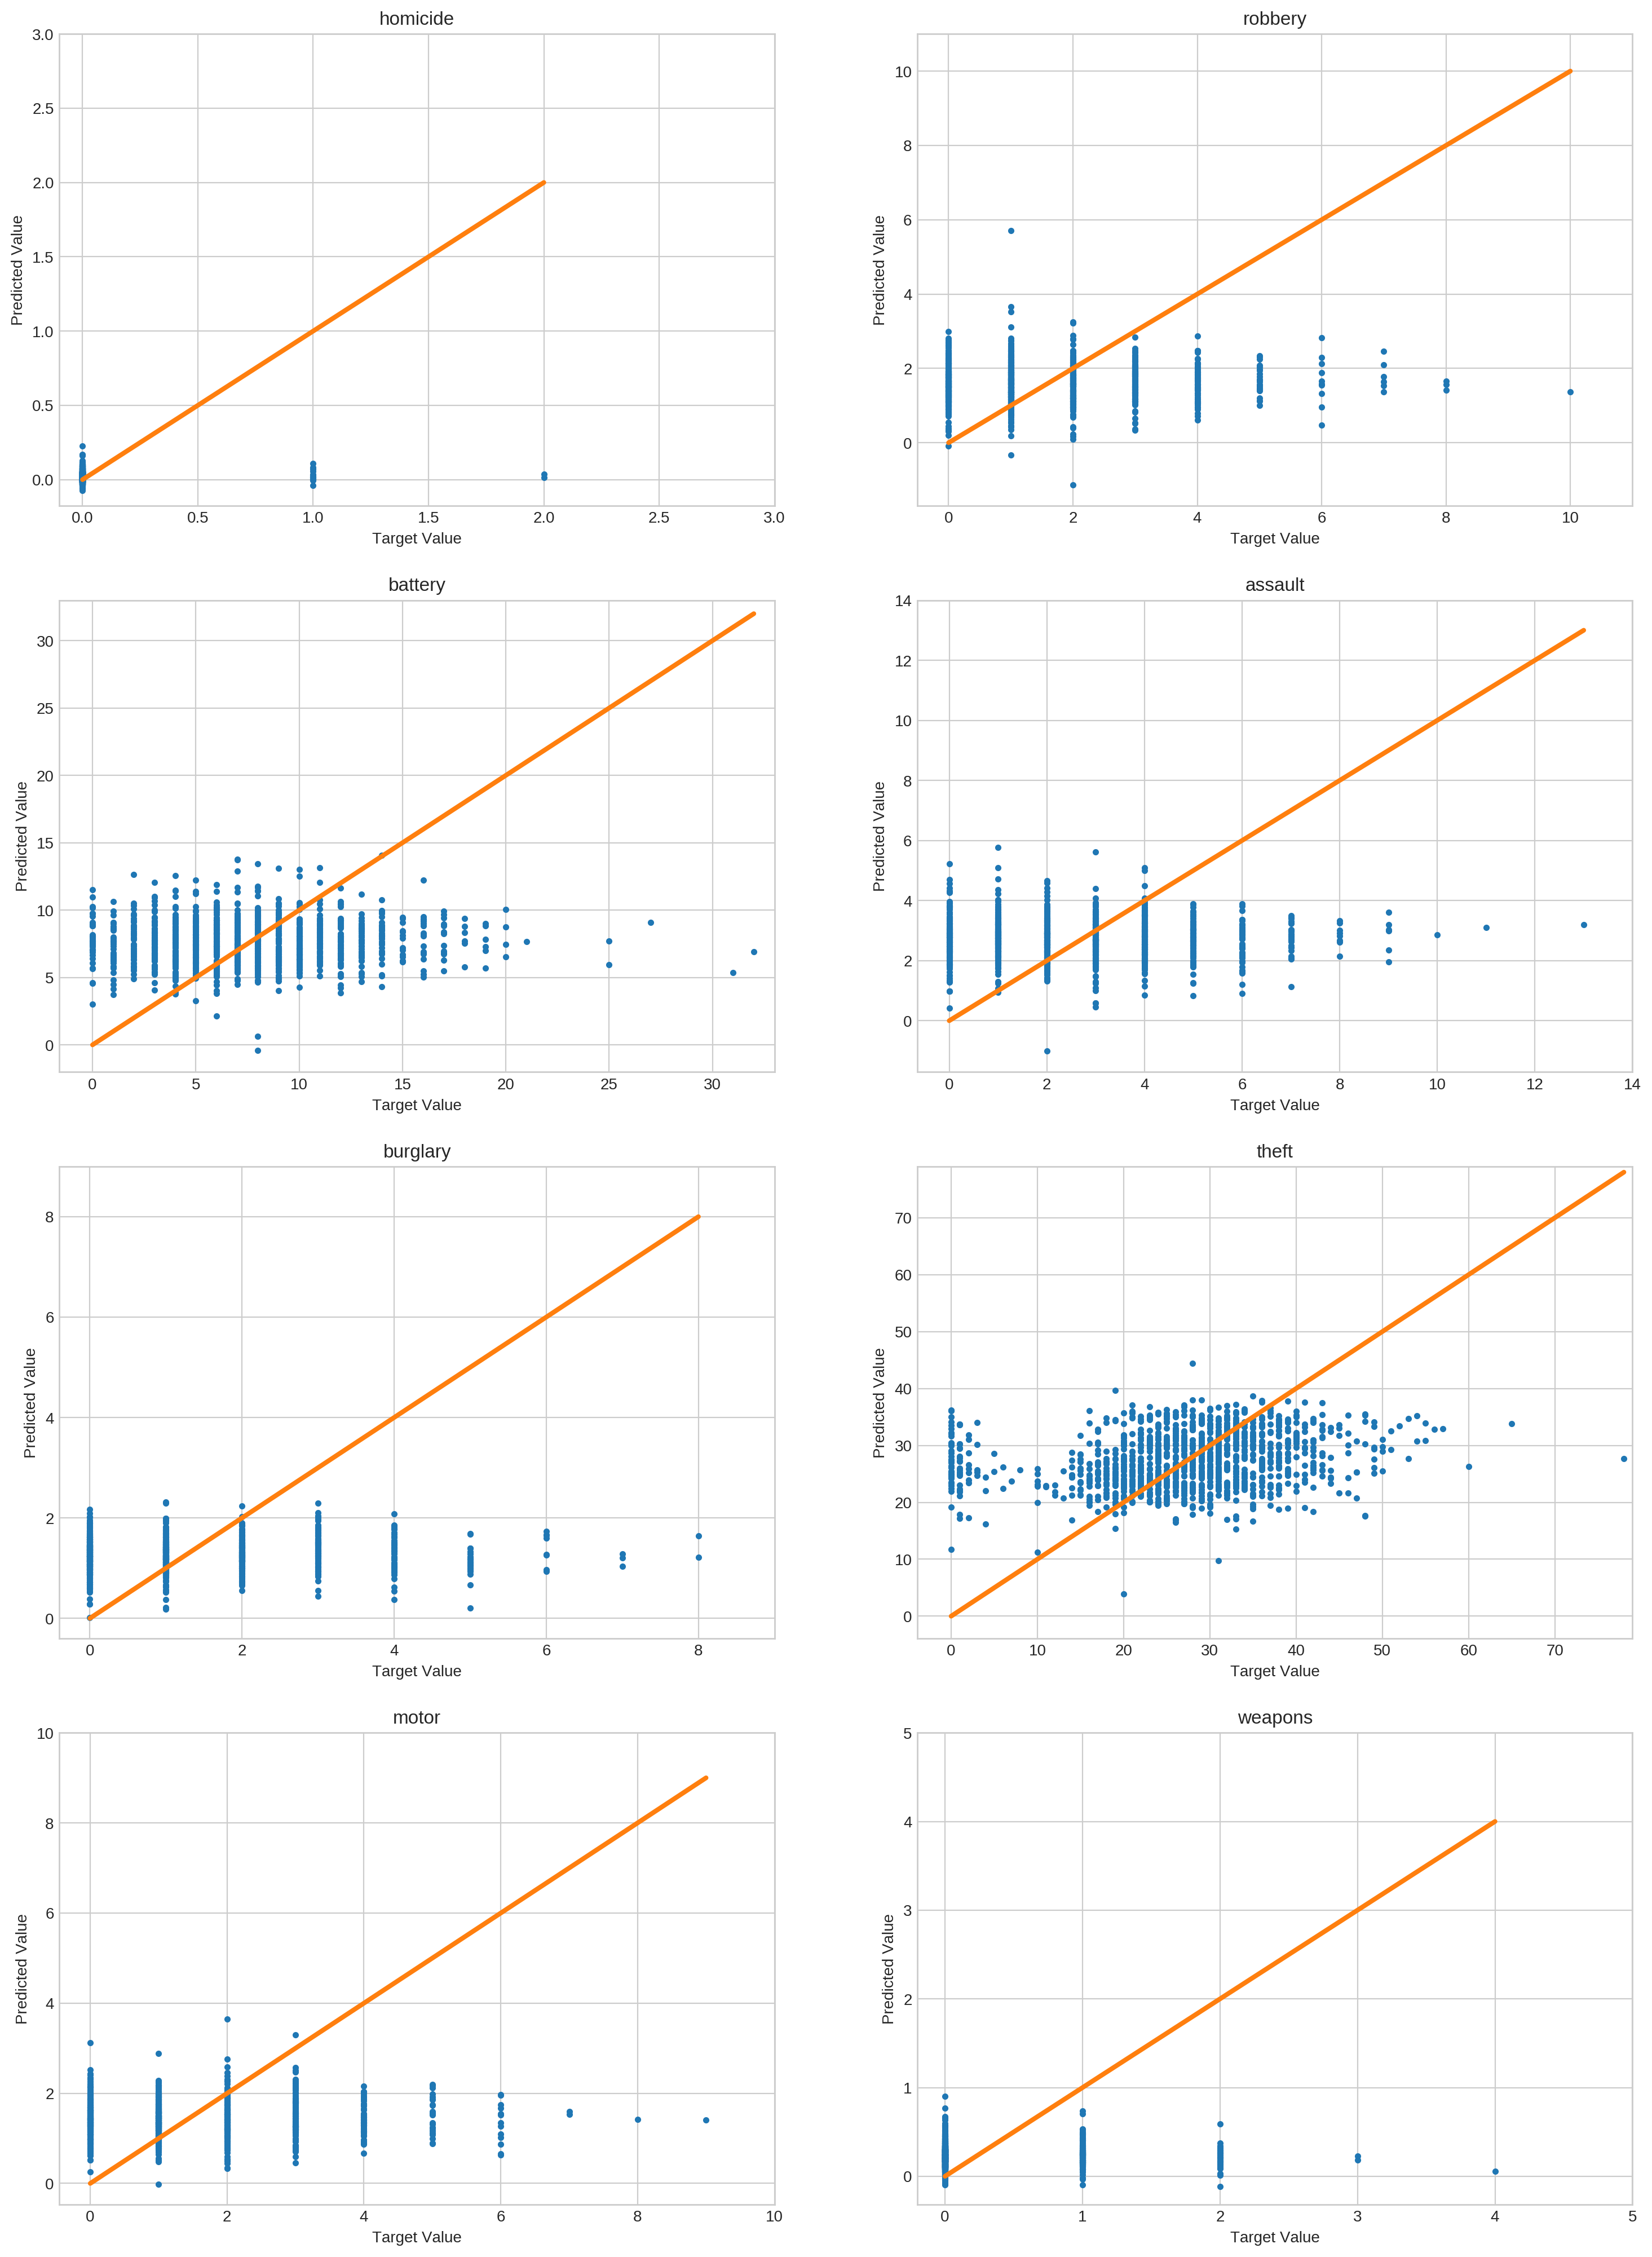

In [74]:
# #############################################################################
# Results V2

col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

plt.figure(figsize=(18,25))

for i in range(T.shape[1]):
    m = np.max(_T[:,i]) + 1
    plt.subplot(4,2,i+1)  
    plt.plot(_T[:,i], Y[:,i], '.'), plt.plot(range(m), lw='3')
    axes = plt.gca()
    axes.set_xlim([None,m]), axes.set_ylim([None,m])
    plt.title(col[i])
    plt.xlabel('Target Value'), plt.ylabel('Predicted Value')
    
plt.show()

### Scikit-Learn

Estimators developed for regression:

- LinearRegression
- Ridge
- Lasso
- SVR (SBR, Linear, Ploynomial)

Linear Regression
train score: 0.0928608791240606
test score: 0.10666113355168351 

Ridge Regression, low alpha
train score: 0.09285424197998593
test score: 0.10669042722417688 

Ridge Regression, high alpha
train score: 0.08511610818128323
test score: 0.09769425918664552 



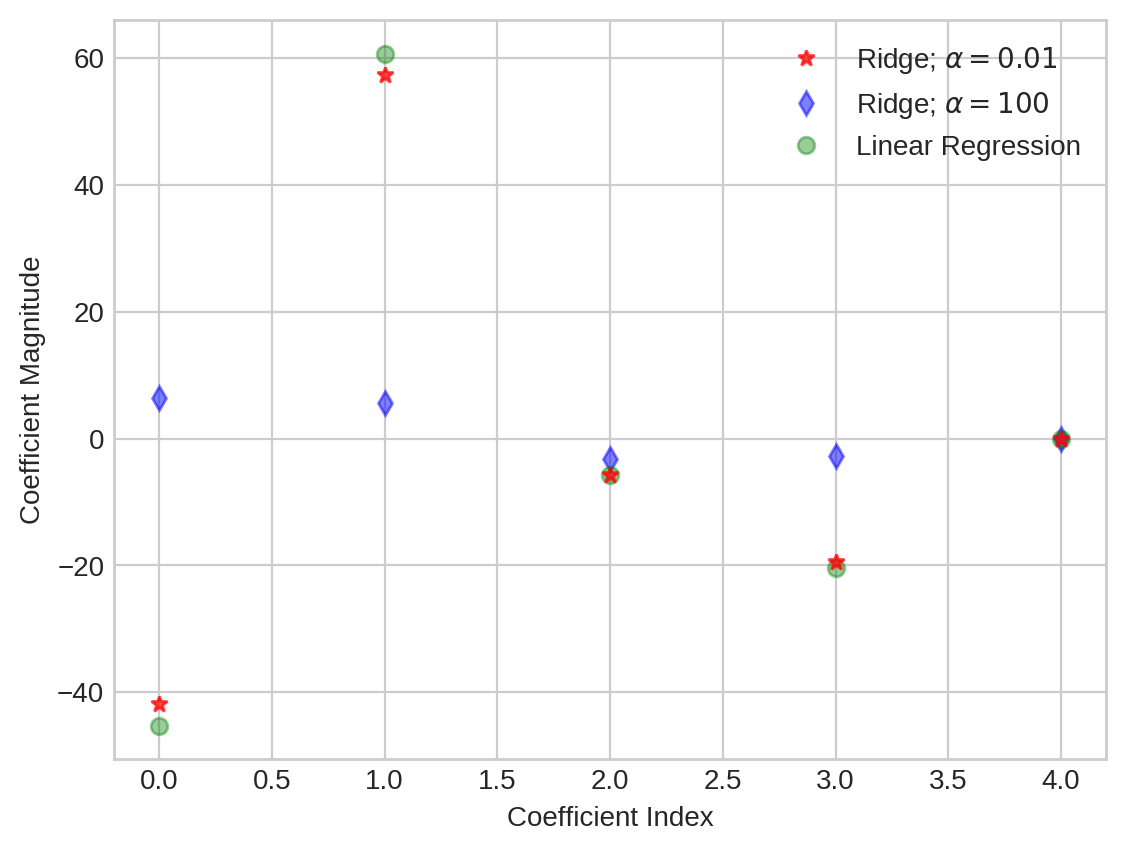

In [38]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# #############################################################################
# Read the data
data = pd.read_csv('data/wc4.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cols = ['homicide', 'robbery', 'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

T = data['theft']
X = data.drop(['date'] + cols, axis=1)

X_train,X_test,T_train,T_test = train_test_split(X, T, test_size=0.3, random_state=3)

# #############################################################################
# Fit regression model
lr = LinearRegression()
lr.fit(X_train, T_train)

train_score = lr.score(X_train, T_train)
test_score = lr.score(X_test, T_test)

print('Linear Regression')
print("train score:", train_score)
print("test score:", test_score, '\n')

rr = Ridge(alpha=0.01)
rr.fit(X_train, T_train)

Ridge_train_score = rr.score(X_train, T_train)
Ridge_test_score = rr.score(X_test, T_test)

print('Ridge Regression, low alpha')
print("train score:", Ridge_train_score)
print("test score:", Ridge_test_score, '\n')

rr100 = Ridge(alpha=100)
rr100.fit(X_train, T_train)

Ridge_train_score100 = rr100.score(X_train, T_train)
Ridge_test_score100 = rr100.score(X_test, T_test)

print('Ridge Regression, high alpha')
print("train score:", Ridge_train_score100)
print("test score:", Ridge_test_score100, '\n')

# #############################################################################
# Results
plt.plot(rr.coef_, alpha=0.7, linestyle='none', marker='*',
         color='red', label=r'Ridge; $\alpha = 0.01$', zorder=7)
plt.plot(rr100.coef_, alpha=0.5, linestyle='none', marker='d',
         color='blue', label=r'Ridge; $\alpha = 100$')
plt.plot(lr.coef_, alpha=0.4, linestyle='none', marker='o',
         color='green', label='Linear Regression')

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')

plt.legend(loc=1)
plt.show()

alpha = 0.1
training score: 0.08383764159721885
test score:  0.09641426707672773
number of features used:  2 

alpha = 0.01
training score: 0.09161555052516179
test score:  0.10566774035324888
number of features used: 3 

alpha = 0.0001
training score: 0.09285435489392024
test score:  0.10668948104653452
number of features used: 4 



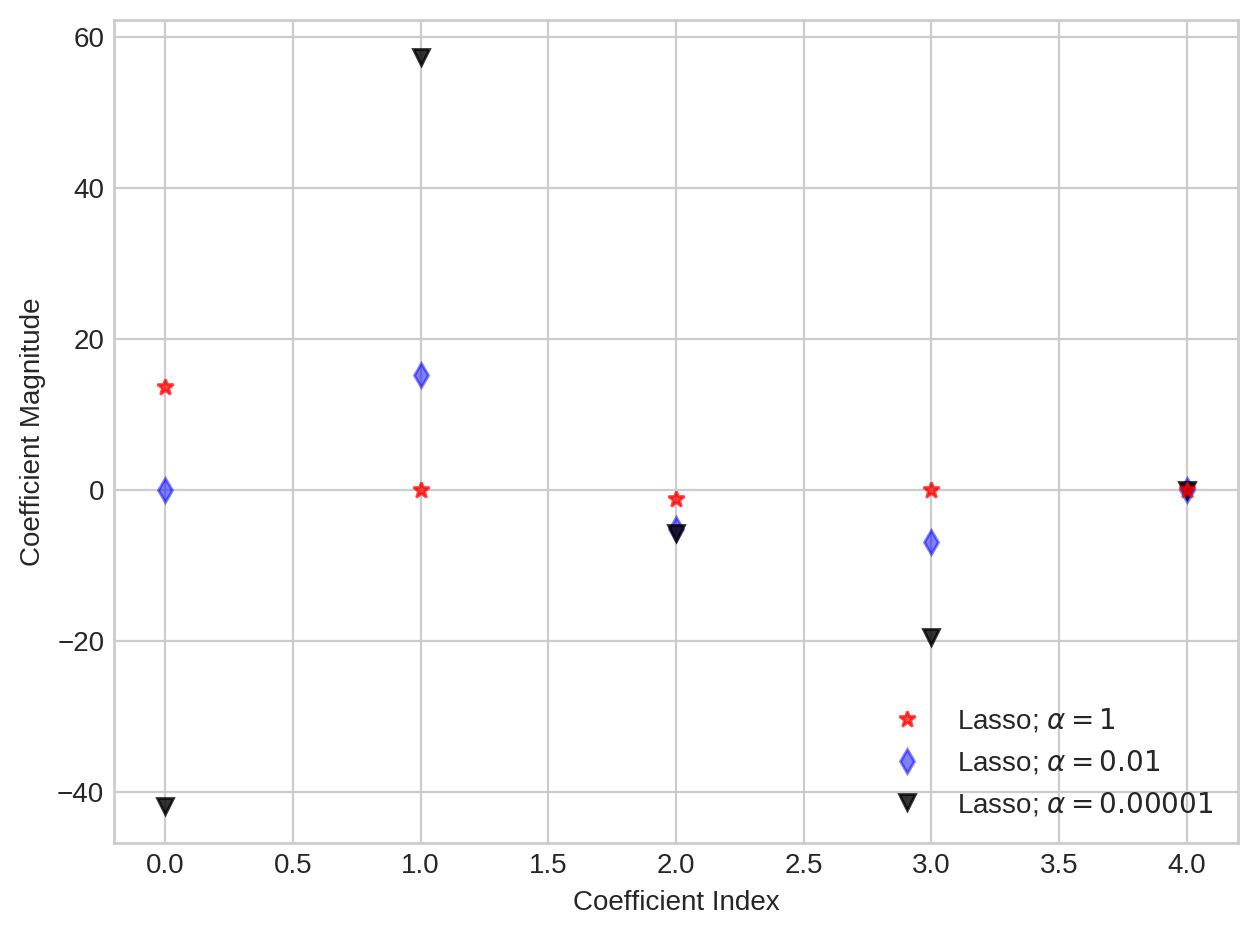

In [29]:
# Difference of lasso and ridge regression is that some of the coefficients can be zero i.e. some of the features are 
# completely neglected
from sklearn.linear_model import Lasso

# #############################################################################
# Read the Data
data = pd.read_csv('data/wc4.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cols = ['homicide', 'robbery', 'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

T = data['theft']
X = data.drop(['date'] + cols, axis=1)

X_train,X_test,T_train,T_test = train_test_split(X, T, test_size=0.3, random_state=3)

# #############################################################################
# Fit regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, T_train)
train_score=lasso.score(X_train, T_train)
test_score=lasso.score(X_test, T_test)
coeff_used = np.sum(lasso.coef_!=0)

print('alpha = 0.1')
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used, '\n')

lasso001 = Lasso(alpha=0.01, max_iter=10e6)
lasso001.fit(X_train, T_train)
train_score001 = lasso001.score(X_train, T_train)
test_score001 = lasso001.score(X_test, T_test)
coeff_used001 = np.sum(lasso001.coef_!=0)

print('alpha = 0.01')
print("training score:", train_score001)
print("test score: ", test_score001)
print("number of features used:", coeff_used001, '\n')

lasso00001 = Lasso(alpha=0.0001, max_iter=10e6)
lasso00001.fit(X_train, T_train)
train_score00001 = lasso00001.score(X_train, T_train)
test_score00001 = lasso00001.score(X_test, T_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)

print('alpha = 0.0001')
print("training score:", train_score00001)
print("test score: ", test_score00001)
print("number of features used:", coeff_used00001, '\n')

# #############################################################################
# Results
plt.plot(lasso.coef_, alpha=0.7, linestyle='none', marker='*',
         color='red', label=r'Lasso; $\alpha = 1$', zorder=7)
plt.plot(lasso001.coef_, alpha=0.5, linestyle='none', marker='d',
         color='blue', label=r'Lasso; $\alpha = 0.01$')
plt.plot(lasso00001.coef_, alpha=0.8, linestyle='none', marker='v',
         color='black', label=r'Lasso; $\alpha = 0.00001$')

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc=4)

plt.tight_layout()
plt.show()

Kernel RBF
training score: 0.08561572619367153
Kernel Linear
training score: 0.0851777638867588
Kernel Ploy
training score: 0.0855194568060641


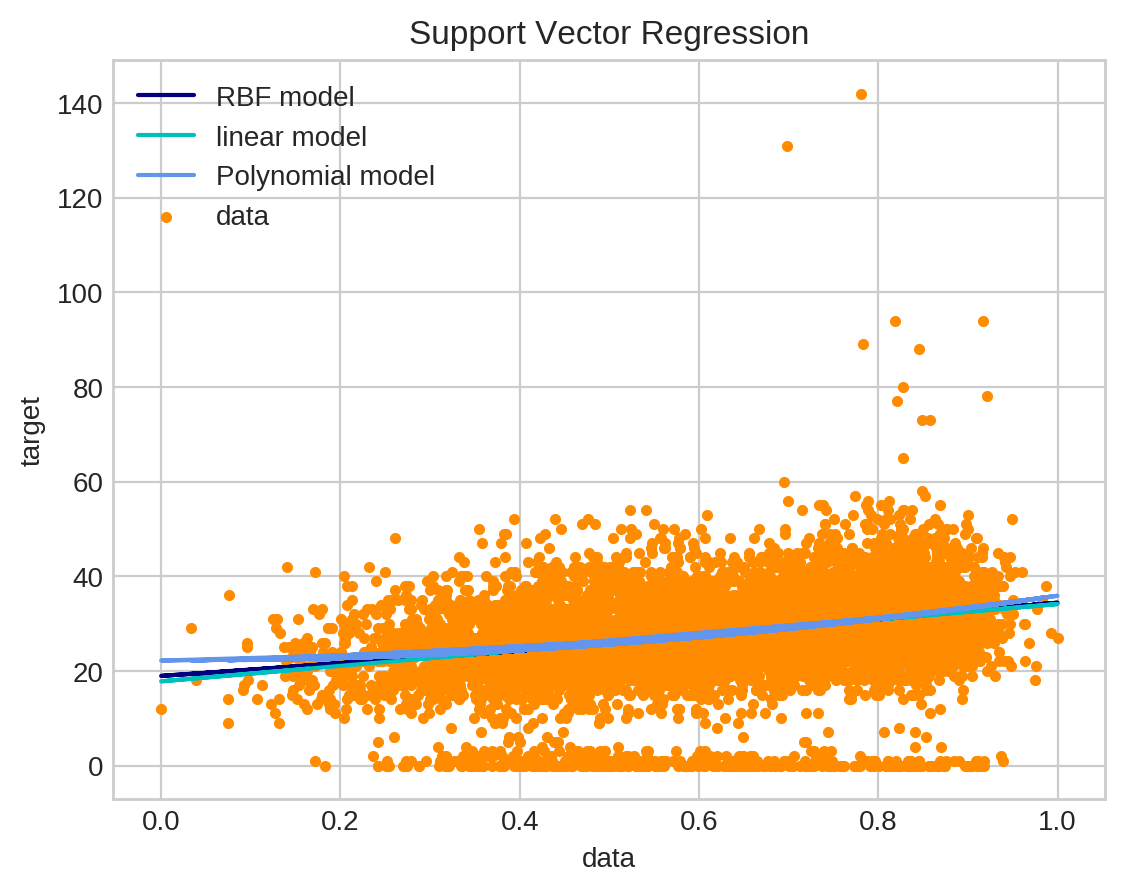

In [35]:
from sklearn.svm import SVR

# #############################################################################
# Read the Data
data = pd.read_csv('data/wc4.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cols = ['homicide', 'robbery', 'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

T = np.array(data['theft'])
X = np.array([[x] for x in data['dry']])

# X_train,X_test,T_train,T_test = train_test_split(X, T, test_size=0.3, random_state=3)

# #############################################################################
# Fit regression model

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf = svr_rbf.fit(X, T)
print('Kernel RBF')
print("training score:", y_rbf.score(X, T))
y_rbf = y_rbf.predict(X)

svr_lin = SVR(kernel='linear', C=1e3)
y_lin = svr_lin.fit(X, T)
print('Kernel Linear')
print("training score:", y_lin.score(X, T))
y_lin = y_lin.predict(X)

svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_poly = svr_poly.fit(X, T)
print('Kernel Ploy')
print("training score:", y_poly.score(X, T))
y_poly = y_poly.predict(X)

# #############################################################################
# Results

lw = 1.5
plt.scatter(X, T, marker='.', color='darkorange', label='data')

plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X, y_lin, color='c', lw=lw, label='linear model')
plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')

plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()